# Binary classifier to predict NV-HAP versus ventilated pneumonias

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBClassifier
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

cwd = Path.cwd()
print(cwd)
datasets = cwd / '../results/tax_classification_out/abundance_matrices'
results = cwd / '../results/ML_out'

/mnt/c/git_repos/pneumonia/ML_scripts


/home/cednotsed/miniconda3/envs/mashin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

### Load data

In [2]:
raw_df = pd.read_csv(datasets / 'RA.G.zeroed.decontam.2.csv')
meta = pd.read_csv(cwd / "../data/metadata/parsed_patient_metadata.filt.csv")
# display(raw_df)
# display(meta)

merged_df = raw_df.merge(meta, on='run_id', how='left')
merged_filt = merged_df.loc[merged_df.hap_vap_cap.isin(['HAP', 'VAP']), :]
merged_filt = merged_filt.loc[merged_filt.sample_type == 'SPU', :]

print(merged_filt.loc[:, 'hap_vap2'].value_counts())
print(merged_filt.loc[:, 'ventilation'].value_counts())
# Response
y = merged_filt.loc[:, 'ventilation'].copy()

# Features
X = merged_filt.loc[:, ~merged_filt.keys().isin(meta.keys())].copy()

# Presence absence
X[X > 0] = 1

# # Add sample type
# X.insert(0, 'sample_type', merged_filt.loc[:, 'sample_type'])

# # Categorical encode variables
# X.replace({'sample_type': {'SPU' : 1, 'ETT' : 2, 'ND-BAL' : 3, 'BAL': 4}}, inplace=True)

# Rename features
X.columns = X.columns.str.replace('[^A-Za-z0-9]+', '_') 
print(X.shape)
print(y.shape)

# Binary encode y
y.loc[y == 'HAP'] = 1
y.loc[y == 'VAP'] = 0
y = y.astype('int')
# y.value_counts()

hap_vap2
VAP       31
NV-HAP    30
V-HAP     10
Name: count, dtype: int64
ventilation
True     41
False    30
Name: count, dtype: int64
(71, 152)
(71,)


In [3]:
n_splits = 3

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'HAP': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'VAP': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,HAP,VAP
Train fold,28,20
Test fold,13,10


In [35]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_splits)
model = XGBClassifier(n_estimators = 500)

precision = make_scorer(precision_score, average='binary')
recall = make_scorer(recall_score, average='binary')
f1 = make_scorer(f1_score, average='binary')
auprc = make_scorer(average_precision_score, average=None)

scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

perm_results = cross_validate(model, X=X, y=y, cv=cv, scoring=scoring)

pd.DataFrame(outer_results).mean(axis=0)

fit_time          0.355125
score_time        0.023181
test_precision    0.622045
test_recall       0.667277
test_AUROC        0.599939
test_F1           0.638646
dtype: float64

### Permutation test

In [34]:
np.random.permutation(y)

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1])

In [43]:
np.random.seed(66)
perm_list = []
for i in range(100):
    print(i)
    # Permute
    y_perm = np.random.permutation(y)
    
    # Cross validation
    perm_results = cross_validate(model, X=X, y=y_perm, cv=cv, scoring=scoring)
    model = XGBClassifier()
    perm_list.append(pd.DataFrame(perm_results).mean(axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [47]:
perm_df = pd.concat(perm_list, axis=1)
sum(perm_df.loc['test_F1',:] > 0.638646)

18

## Model training and evaluation

In [5]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 1000, 100)
    max_depth = range(1, 5, 1)
    # gamma = np.linspace(0.1, 3, 10)
    colsample_bytree = np.linspace(0.1, 1, 10)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree)
                      # gamma=gamma,)
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = GridSearchCV(model, 
                         param_grid, 
                         scoring='f1',
                         n_jobs=16, 
                         cv=inner_cv, 
                         verbose=1)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


In [6]:
raw_results, raw_params = optimise_evaluate(X, y)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'colsample_bytree': 0.2, 'max_depth': 4, 'n_estimators': 600}
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits


In [7]:
raw_results

test_precision    0.708606
test_recall       0.805861
test_F1           0.746898
test_AUROC        0.699359
dtype: float64

In [8]:
# From XGboost_external_validation notebook
# raw_params = {'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.1473684210526316}
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

explainer_raw = shap.TreeExplainer(raw_model, model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

Text(0.5, 68.7222222222222, 'SHAP Value')

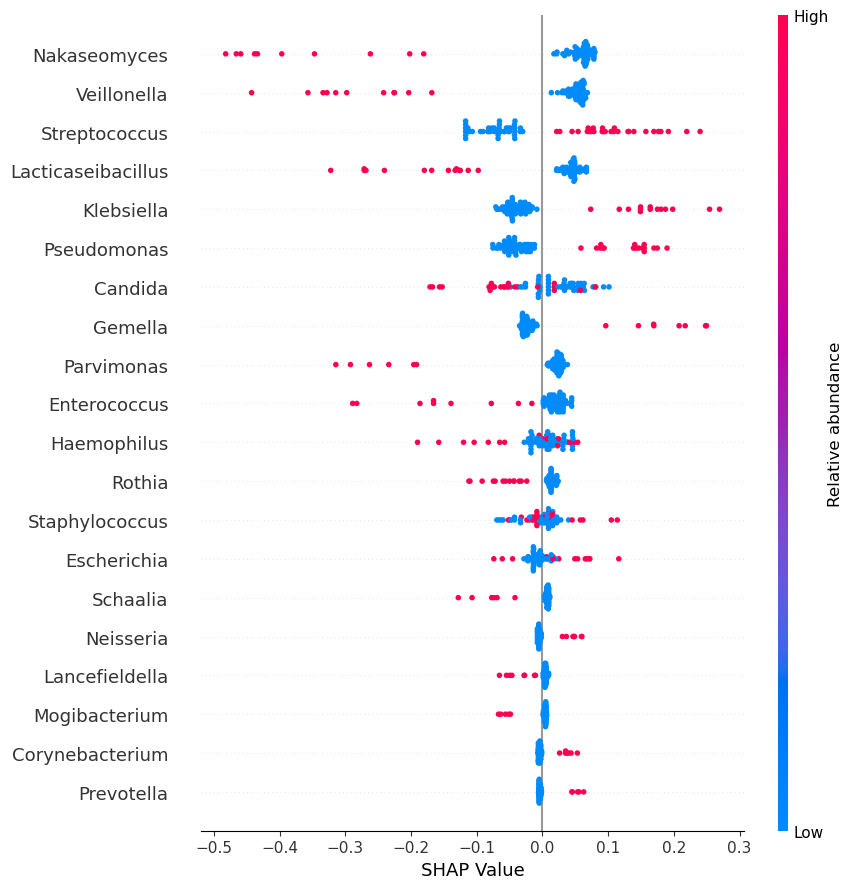

In [9]:
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=X, y=y)

pre_explainer = shap.TreeExplainer(pre_model, model_output='probability', data=X)
shap_pre = pre_explainer.shap_values(X)

shap.summary_plot(shap_pre, X, 
                  show=False, 
                  plot_size=(9, 9), 
                  color_bar_label='Relative abundance',
                  max_display=20)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
# plt.savefig(results / 'shap_plot.ventilation.pdf', dpi=600)

In [8]:
raw_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1473684210526316, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=220, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
# Convert SHAP values to dataframe
shap_df = pd.DataFrame(shap_raw, columns=X.columns)
shap_df = pd.concat([pathogen, shap_df], axis = 1)
display(shap_df)

NameError: name 'pathogen' is not defined

In [59]:
# Get only septic
shap_df = shap_df.loc[shap_df.pathogen != 'none', :]

# Loop through all confirmed and get mean absolute shap value
mean_vals = []
genus_names = []
for p in shap_df.pathogen.unique():
    values = shap_df.loc[shap_df.pathogen == p, p]
    mean_vals = mean_vals + list(values)
    genus_names = genus_names + [p] * len(values)

plot_df = pd.DataFrame({'Genus': genus_names, 'shap': mean_vals})
display(plot_df)
plot_df.to_csv(results / 'SHAP_values_per_infection.csv', index=False, header=True)

,Genus,shap
0,Escherichia,0.083723
1,Escherichia,0.115786
2,Escherichia,0.142420
3,Escherichia,0.137115
4,Escherichia,0.134323
...,...,...
112,Serratia,0.008682
113,Aerococcus,0.000000
114,Lymphocryptovirus,0.032555
115,Campylobacter,0.026858


### Force plot for septic patient (Karius-CR)

Actual Classification 1
202


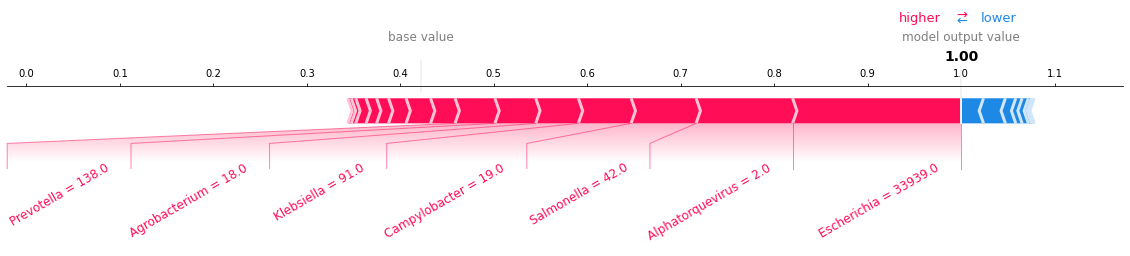

In [22]:
raw_CR = X[['Bacillus', 'Burkholderia', 'Enterococcus', 'Aeromonas', 'Cronobacter',
       'Cytomegalovirus', 'Lymphocryptovirus', 'Campylobacter', 'Pantoea',
       'Shigella', 'Klebsiella', 'Cellulomonas', 'Salmonella', 'Shewanella',
       'Megasphaera', 'Stenotrophomonas', 'Agrobacterium', 'Oerskovia',
       'Prevotella', 'Escherichia', 'Blautia', 'Bacteroides', 'Enterobacter',
       'Alphatorquevirus', 'Veillonella']].copy()

raw_CR_params = {'subsample': 0.8, 'scale_pos_weight': 1.452991452991453, 'n_estimators': 240, 'max_depth': 1, 'gamma': 1.711111111111111, 'colsample_bytree': 0.9052631578947369}
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

j = 202

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True,
                text_rotation=30)

plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')
plt.show()